Library import step

In [1]:
import os
import sys
import numpy as np
import torch
import glob
from matplotlib import pyplot as plt
from PIL import Image as im
import cv2
from torchvision.utils import save_image

In [2]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

GPU check

In [3]:
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print(device)

cuda:0


PCA part

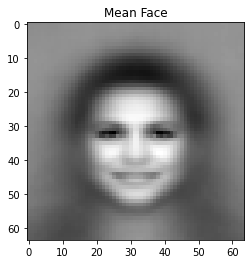

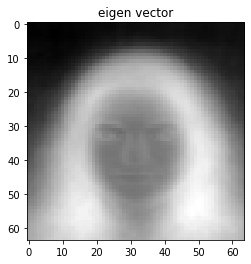

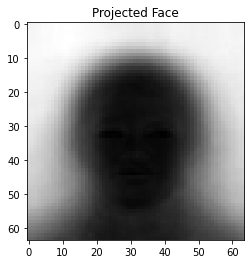

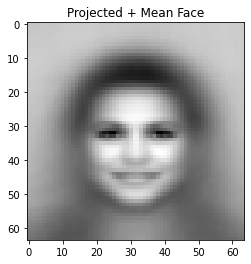

In [9]:
class PCA(nn.Module):
    def __init__(self, ngpu):
        super(PCA, self).__init__()
        self.ngpu = ngpu
        neutral = []

        for i in range(2000):

            i += 1
            img = im.open(f'celeba/img_align_celeba/image{i}.jpg').convert('L') 
            
            img = img.resize((64,64), im.ANTIALIAS) 
            
            img2 = np.array(img).flatten() 
                      
            neutral.append(img2)

        faces_matrix = np.vstack(neutral)
        mean_face = np.mean(faces_matrix, axis=0)
        plt.imshow(mean_face.reshape(64,64),cmap='gray'); 
        plt.title('Mean Face')
        plt.show()
          

        faces_norm = faces_matrix - mean_face
        faces_norm.shape
        
        # Calculate covariance matrix
        face_cov = np.cov(faces_norm.T) #np.cov expects features as rows and observations as columns, so transposed
        face_cov.shape
        
        eigen_vecs, eigen_vals, _ = np.linalg.svd(face_cov)
        img = eigen_vecs[:,1].reshape(64,64)      

        plt.imshow(img, cmap='gray')
        plt.title('eigen vector')
        plt.show()
        #print(img)
        #print("eigen_vecs.shape")
        # print(eigen_vecs.shape)

        
        # mean_array = mean_face.reshape(64,64)
        # mean_image = im.fromarray(mean_array.astype('uint8'),'L')
        # mean_image = mean_image.convert('L')

        weight = faces_norm[0,:].dot(eigen_vecs[:,:1]) # Get PC scores of the images
        #print("weight.shape")
        #print(weight.shape)

        projected_face = weight.dot(eigen_vecs[:,:1].T) # Reconstruct first face in dataset using k PCs
        #print("projected_face.shape")
        # print(projected_face.shape)
        plt.imshow(projected_face.reshape(64,64),cmap='gray')
        plt.title('Projected Face')
        plt.show()
        

        projected_face = projected_face + mean_face
        #print("projected_mean_face.shape")
        # print(projected_face.shape)
        # print(projected_face)

        plt.imshow(projected_face.reshape(64,64)+mean_face.reshape(64,64),cmap='gray');
        plt.title('Projected Face')
        plt.show()



    

        #self.pca = eigen_vecs[:,1]
        self.pca = projected_face

        # nv + PCA add @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        ##mul_image = cv2.add(src1, src2)
            
pca_= PCA(ngpu).to(device)

In [10]:
eigenface = pca_.pca
eigenface = torch.Tensor(eigenface)


eigenface = eigenface.reshape(1,64,64)
eigenface = torch.unsqueeze(eigenface, dim=0)

# print("eigenface unsqueeze shape")
# print(eigenface.shape)

# #eigenface = torch.squeeze(eigenface, dim=0)

# print("eigenface shape")
print(eigenface.shape)


#w, h =64,64

# #src2 = np.stack([src1, src1, src1], axis=1)
#src2 = torch.Tensor(src1)
# print(" src shape")
# print(src1.shape)

fixed_noise = torch.randn(1, 100, 1, 1, device=device)
#print("fixed_noise shape")
#print(fixed_noise.shape)
#print(fixed_noise)

torch.Size([1, 1, 64, 64])


In [11]:
class PCAConv(nn.Module):
    def __init__(self,npgu):
        super(PCAConv, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # nn.ReLU(nn.MaxPool2d(nn.Conv2d(1, 32, 3,1,1, bias=False),2)),
            # nn.ReLU(nn.MaxPool2d(nn.Conv2d(32, 64, 3,1,1, bias=False),2)),
            # nn.ReLU(nn.MaxPool2d(nn.Conv2d(64, 98, 3,1,1, bias=False),2)),
            # nn.ReLU(nn.MaxPool2d(nn.Conv2d(98, 100, 3,1,1, bias=False),2)),
            # #nn.Conv1d(1,100,1,1,0,bias=False),
            #nn.AdaptiveAvgPool2d(1)
            
            nn.Conv2d(1, 32, 4,2,1, bias=False),
            nn.Conv2d(32, 64, 4,2,1, bias=False),
            nn.Conv2d(64, 96, 4,2,1, bias=False),
            nn.Conv2d(96, 100, 4,2,1, bias=False),
            nn.AdaptiveAvgPool2d(1)
            
# ############################### 1st
#             # input is (nc) x 64 x 64
#             nn.Conv2d(1, 64, 4, 2, 1, bias=False),
#             #nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf) x 32 x 32
#             nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
#             #nn.BatchNorm2d(64 * 2),
#             #nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*2) x 16 x 16
#             nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
#             # nn.BatchNorm2d(64 * 4),
#             # nn.LeakyReLU(0.2, inplace=True),
#             # # state size. (ndf*4) x 8 x 8
#             nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
#             # nn.BatchNorm2d(64 * 8),
#             # nn.LeakyReLU(0.2, inplace=True),
#             # # state size. (ndf*8) x 4 x 4

#             #nn.Conv2d(64 * 8, 100, 1, 1, 1, bias=False),
#             nn.Conv2d(64 * 8, 64*16, 4, 2, 1, bias=False),
#             #nn.Sigmoid()
#             nn.Conv2d(64*16, 100, 1, 1,1 ,bias=False),

############################### 1st
        )
    
    def forward(self, input):
        return self.main(input)

pca_conv= PCAConv(ngpu).to(device)
en = pca_conv(eigenface)

print("en.shape")
print(en.shape)
print(en)

# img = eigenface.reshape(64,64)      
# plt.imshow(img, cmap='gray')
# plt.show()

nnz = en.clone().detach()

print("nnz.shape")
print(nnz.shape)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor